In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import entropy, skew, kurtosis
import pywt

In [2]:
project_root = os.path.dirname(os.getcwd())
data_path = os.path.join(project_root,'data')
interim_path = data_path + '/interim'
data = interim_path + '/datos.csv'
df = pd.read_csv(data)

processed_path = data_path +'/processed'

# Preprocessing

## Normalización o estandarización

In [3]:
df.iloc[:, -3:] = (df.iloc[:, -3:] - df.iloc[:, -3:].mean()) / df.iloc[:, -3:].std()

In [4]:
df

,Unnamed: 0,id_person,activity,timestamp,x,y,z
0,966746,1,Downstairs,"17-03-1970, 20:15:42",-0.118684,0.280806,-0.157985
1,966747,1,Downstairs,"17-03-1970, 20:16:32",-0.080722,0.286735,0.494081
2,966748,1,Downstairs,"17-03-1970, 20:17:22",-0.689566,0.021401,0.759115
3,966749,1,Downstairs,"17-03-1970, 20:18:12",-0.515819,0.099964,0.588736
4,966750,1,Downstairs,"17-03-1970, 20:19:02",-0.124524,0.412732,0.927390
...,...,...,...,...,...,...,...
1098204,231259,36,Walking,"04-06-1970, 17:38:12",-0.420916,-0.138689,1.056650
1098205,231260,36,Walking,"04-06-1970, 17:39:02",-0.543560,-0.229110,1.194168
1098206,231261,36,Walking,"04-06-1970, 17:39:52",-0.606343,-0.211322,1.131139
1098207,231262,36,Walking,"04-06-1970, 17:40:42",-0.701247,-0.154994,1.162654


## Division en ventanas temporales

### Análisis
1. La frecuencia de muestro, como mi dataset es de sensores a 50hz, 128 datos equivales a 2.56 segundos (128/50 = 2.56).
2. En el reconocimiento de actividades humanas, 128 (2.56s) y 256 (5.12) muestras son las más usadas. Porque ventanas más cortas (<1s) pueden perder contexto y ventanas muy largas (>5s) pueden mezclar actividades distintas.
3. Se suele usar un overlap del 50% para no perder eventos en los bordes de las ventanas.

128 muestras es el estándar para empezar, si las actividades son muy rápidas, probaremos con 64 muestras (1.28s) y si son lentas, probaremos con 256 muestras (5.12s).

In [5]:
# 128 muestras sin overlap
window_size = 128
windows = []
for i in range(0, len(df), window_size):
    if len(df.iloc[i: i+window_size] == window_size):
        windows.append(df.iloc[i:i+window_size])

In [5]:
# con overlap 50%
window_size = 128
step = window_size // 2
windows = []
for i in range(0, len(df)-window_size+1, step):
        windows.append(df.iloc[i:i+window_size])

## Análisis del balance de clases

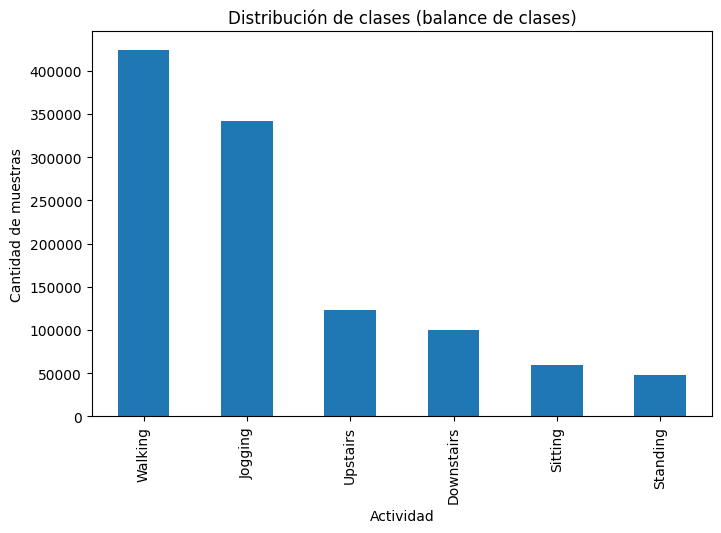

In [6]:
class_counts = df['activity'].value_counts()

plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar')
plt.xlabel('Actividad')
plt.ylabel('Cantidad de muestras')
plt.title('Distribución de clases (balance de clases)')
plt.show()

#  Extracción de características

## Estadísticas por ventana

In [7]:
activity_categories = df['activity'].unique()

In [8]:
def extract_window_features(windows):
    feature_list = []
    for window in windows:
        feats = {}
        for axis in ['x', 'y', 'z']:
            series = window[axis]
            feats[f'mean_{axis}'] = series.mean()
            feats[f'var_{axis}'] = series.var()
            # Si la varianza es cero, skew y kurtosis serán NaN; ponlos a 0
            s = skew(series)
            k = kurtosis(series)
            feats[f'skew_{axis}'] = 0 if np.isnan(s) else s
            feats[f'kurtosis_{axis}'] = 0 if np.isnan(k) else k
            feats[f'energy_{axis}'] = np.sum(series**2) / len(series)
            hist, _ = np.histogram(series, bins=10, density=True)
            feats[f'entropy_{axis}'] = entropy(hist + 1e-12)
        #feats['label'] = window['activity'].mode()[0]
        feats['label'] = pd.Categorical([window['activity'].mode()[0]], categories=activity_categories).codes[0]
        feature_list.append(feats)
    return pd.DataFrame(feature_list)

In [9]:
features_df = extract_window_features(windows)

/tmp/ipykernel_13632/3686270435.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  s = skew(series)
/tmp/ipykernel_13632/3686270435.py:11: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  k = kurtosis(series)
/tmp/ipykernel_13632/3686270435.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  s = skew(series)
/tmp/ipykernel_13632/3686270435.py:11: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  k = kurtosis(series)
/tmp/ipykernel_13632/3686270435.py:10: RuntimeWarning: Precision loss occurr

In [10]:
features_df

,mean_x,var_x,skew_x,kurtosis_x,energy_x,entropy_x,mean_y,var_y,skew_y,kurtosis_y,energy_y,entropy_y,mean_z,var_z,skew_z,kurtosis_z,energy_z,entropy_z,label
0,-0.470215,0.288398,0.378699,0.644527,0.507248,1.867009,0.355466,0.428597,0.229452,-0.604363,0.551604,2.201265,0.268635,0.925778,0.681862,0.007322,0.990710,2.096529,0
1,-0.863564,0.628538,0.029255,-0.377260,1.369370,2.093253,0.208879,0.561356,0.141352,-0.873759,0.600601,2.164025,0.156463,0.942664,0.996498,0.791344,0.959780,1.945266,0
2,-1.275563,0.633436,0.238717,-0.305265,2.255547,2.144883,-0.079222,0.575129,0.166304,-0.609631,0.576912,2.171129,0.114394,0.661184,0.531660,1.123467,0.669105,1.864655,0
3,-1.373968,0.468110,-0.266900,-0.150604,2.352242,2.000736,-0.238282,0.562580,0.214980,-0.736255,0.614963,2.180837,0.065160,0.529830,0.471664,0.520047,0.529936,1.879637,0
4,-1.366178,0.567709,0.189108,-0.106917,2.429714,2.048567,-0.217066,0.584067,0.406382,-0.678097,0.626622,2.183482,0.097238,0.596212,0.598043,0.807840,0.601009,1.903840,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17153,-0.205420,0.101342,0.176658,-0.292691,0.142748,2.156201,0.372038,0.269827,-0.056957,-1.000080,0.406131,2.220503,0.044380,0.491102,1.399117,2.527037,0.489235,1.815078,3
17154,-0.206869,0.093957,0.388390,-0.285017,0.136018,2.126799,0.388482,0.235623,-0.075933,-0.803554,0.384701,2.209061,0.066539,0.442961,1.358210,2.370603,0.443928,1.801049,3
17155,-0.231667,0.091918,0.470118,0.318244,0.144869,1.991511,0.398534,0.157964,-0.101745,-0.663953,0.315560,2.187926,0.034800,0.357806,1.117134,1.744142,0.356222,1.762996,3
17156,-0.210861,0.092984,0.311666,0.250665,0.136720,2.048276,0.393056,0.133962,0.118734,-0.516750,0.287408,2.074755,0.046529,0.327358,1.053557,1.643575,0.326965,1.725049,3


In [11]:
features_df.to_csv(os.path.join(processed_path, 'features_temporales_labelNum_overlap50.csv'))

In [24]:
features_df

,mean_x,var_x,skew_x,kurtosis_x,energy_x,entropy_x,mean_y,var_y,skew_y,kurtosis_y,energy_y,entropy_y,mean_z,var_z,skew_z,kurtosis_z,energy_z,entropy_z,label
0,-0.470215,0.288398,0.378699,0.644527,0.507248,1.867009,0.355466,0.428597,0.229452,-0.604363,0.551604,2.201265,0.268635,0.925778,0.681862,0.007322,0.990710,2.096529,Downstairs
1,-0.863564,0.628538,0.029255,-0.377260,1.369370,2.093253,0.208879,0.561356,0.141352,-0.873759,0.600601,2.164025,0.156463,0.942664,0.996498,0.791344,0.959780,1.945266,Downstairs
2,-1.275563,0.633436,0.238717,-0.305265,2.255547,2.144883,-0.079222,0.575129,0.166304,-0.609631,0.576912,2.171129,0.114394,0.661184,0.531660,1.123467,0.669105,1.864655,Downstairs
3,-1.373968,0.468110,-0.266900,-0.150604,2.352242,2.000736,-0.238282,0.562580,0.214980,-0.736255,0.614963,2.180837,0.065160,0.529830,0.471664,0.520047,0.529936,1.879637,Downstairs
4,-1.366178,0.567709,0.189108,-0.106917,2.429714,2.048567,-0.217066,0.584067,0.406382,-0.678097,0.626622,2.183482,0.097238,0.596212,0.598043,0.807840,0.601009,1.903840,Downstairs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17153,-0.205420,0.101342,0.176658,-0.292691,0.142748,2.156201,0.372038,0.269827,-0.056957,-1.000080,0.406131,2.220503,0.044380,0.491102,1.399117,2.527037,0.489235,1.815078,Walking
17154,-0.206869,0.093957,0.388390,-0.285017,0.136018,2.126799,0.388482,0.235623,-0.075933,-0.803554,0.384701,2.209061,0.066539,0.442961,1.358210,2.370603,0.443928,1.801049,Walking
17155,-0.231667,0.091918,0.470118,0.318244,0.144869,1.991511,0.398534,0.157964,-0.101745,-0.663953,0.315560,2.187926,0.034800,0.357806,1.117134,1.744142,0.356222,1.762996,Walking
17156,-0.210861,0.092984,0.311666,0.250665,0.136720,2.048276,0.393056,0.133962,0.118734,-0.516750,0.287408,2.074755,0.046529,0.327358,1.053557,1.643575,0.326965,1.725049,Walking


In [25]:
features_df.to_csv(processed_path+'/features_temporales.csv')

In [3]:
features_df = pd.read_csv(processed_path+'/features_temporales.csv')

In [4]:
features_df

,Unnamed: 0,mean_x,var_x,skew_x,kurtosis_x,energy_x,entropy_x,mean_y,var_y,skew_y,kurtosis_y,energy_y,entropy_y,mean_z,var_z,skew_z,kurtosis_z,energy_z,entropy_z,label
0,0,-0.470215,0.288398,0.378699,0.644527,0.507248,1.867009,0.355466,0.428597,0.229452,-0.604363,0.551604,2.201265,0.268635,0.925778,0.681862,0.007322,0.990710,2.096529,Downstairs
1,1,-1.275563,0.633436,0.238717,-0.305265,2.255547,2.144883,-0.079222,0.575129,0.166304,-0.609631,0.576912,2.171129,0.114394,0.661184,0.531660,1.123467,0.669105,1.864655,Downstairs
2,2,-1.366178,0.567709,0.189108,-0.106917,2.429714,2.048567,-0.217066,0.584067,0.406382,-0.678097,0.626622,2.183482,0.097238,0.596212,0.598043,0.807840,0.601009,1.903840,Downstairs
3,3,-1.430329,0.529991,0.384774,0.206840,2.571691,2.055396,-0.262068,0.465226,0.379390,-0.368356,0.530271,2.076100,0.098470,0.616801,0.635977,0.976240,0.621679,1.902144,Downstairs
4,4,-1.396508,0.497145,0.414596,0.085174,2.443496,2.078037,-0.267511,0.455613,0.644140,-0.294721,0.523616,2.108096,0.099407,0.559990,0.652242,0.660335,0.565497,1.932747,Downstairs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8575,8575,-0.230218,0.119226,0.272107,0.222483,0.171295,1.959175,0.394736,0.220722,-0.169524,-0.652572,0.374814,2.223445,0.018282,0.412887,1.396312,2.816103,0.409995,1.717582,Walking
8576,8576,-0.225245,0.098343,0.194295,-0.016344,0.148310,2.049152,0.359507,0.234198,-0.096337,-0.979922,0.361614,2.238524,0.048028,0.498013,1.229989,1.697716,0.496429,1.808183,Walking
8577,8577,-0.206869,0.093957,0.388390,-0.285017,0.136018,2.126799,0.388482,0.235623,-0.075933,-0.803554,0.384701,2.209061,0.066539,0.442961,1.358210,2.370603,0.443928,1.801049,Walking
8578,8578,-0.210861,0.092984,0.311666,0.250665,0.136720,2.048276,0.393056,0.133962,0.118734,-0.516750,0.287408,2.074755,0.046529,0.327358,1.053557,1.643575,0.326965,1.725049,Walking


## Transformadas

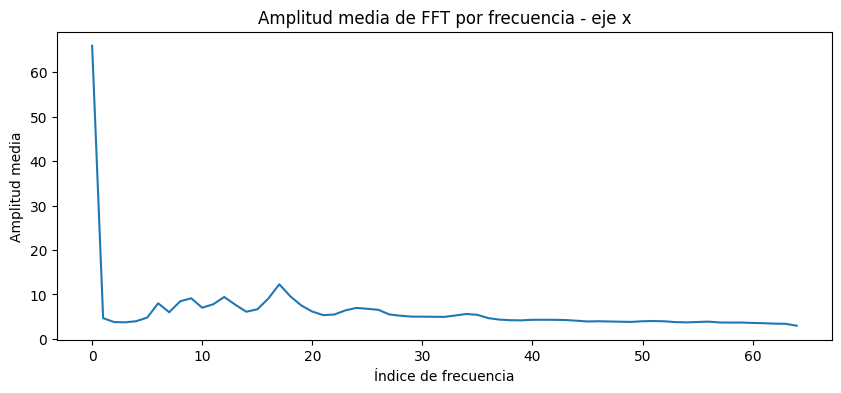

[x] Para cubrir el 90% de la energía, usa K=54


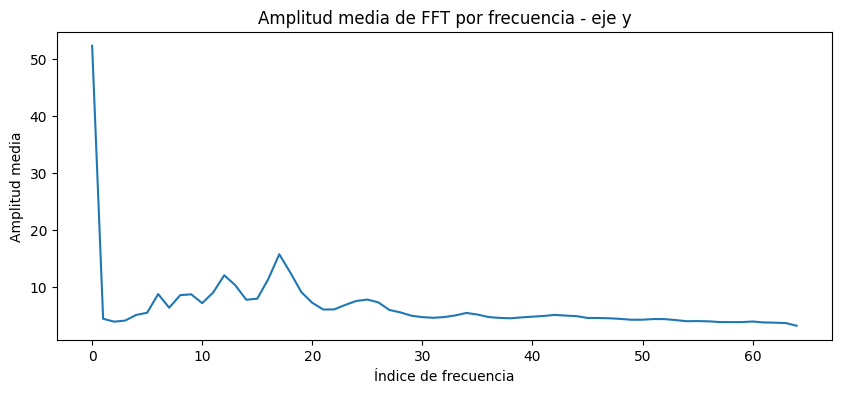

[y] Para cubrir el 90% de la energía, usa K=54


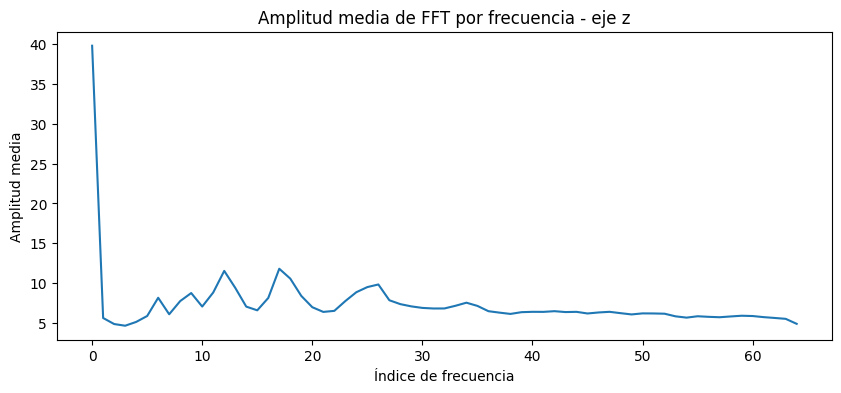

[z] Para cubrir el 90% de la energía, usa K=57


In [12]:
for axis in ['x', 'y', 'z']:
    fft_ampls = []
    for window in windows:
        if len(window) != window_size:
            continue  # skip windows with unexpected length
        serie = window[axis].values.astype(float)
        fft_vals = np.fft.rfft(serie)
        fft_ampls.append(np.abs(fft_vals))
    if not fft_ampls:
        continue  # skip if no valid windows
    fft_ampls = np.stack(fft_ampls)  # ensures 2D array
    mean_fft = fft_ampls.mean(axis=0)

    plt.figure(figsize=(10,4))
    plt.plot(mean_fft)
    plt.title(f"Amplitud media de FFT por frecuencia - eje {axis}")
    plt.xlabel("Índice de frecuencia")
    plt.ylabel("Amplitud media")
    plt.show()

    energy = np.cumsum(mean_fft) / np.sum(mean_fft)
    K = np.argmax(energy >= 0.9) + 1
    print(f"[{axis}] Para cubrir el 90% de la energía, usa K={K}")

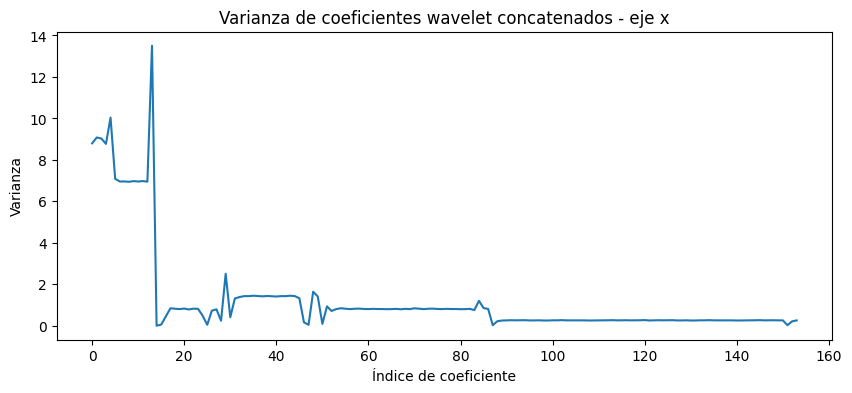

[x] Se seleccionaron 154 coeficientes wavelet con varianza > 0.001


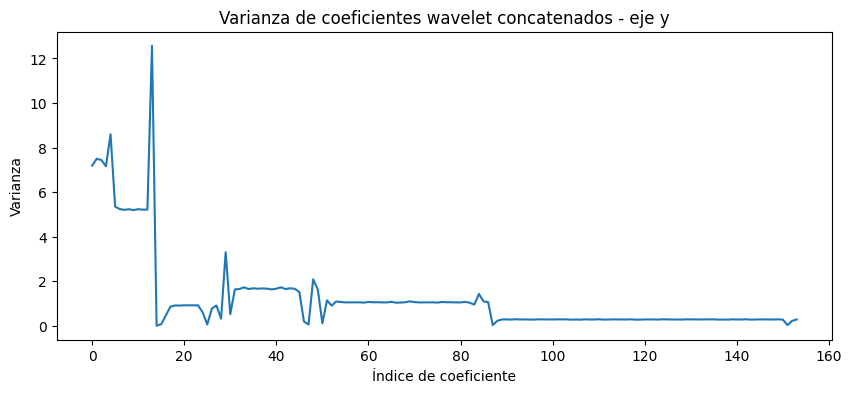

[y] Se seleccionaron 154 coeficientes wavelet con varianza > 0.001


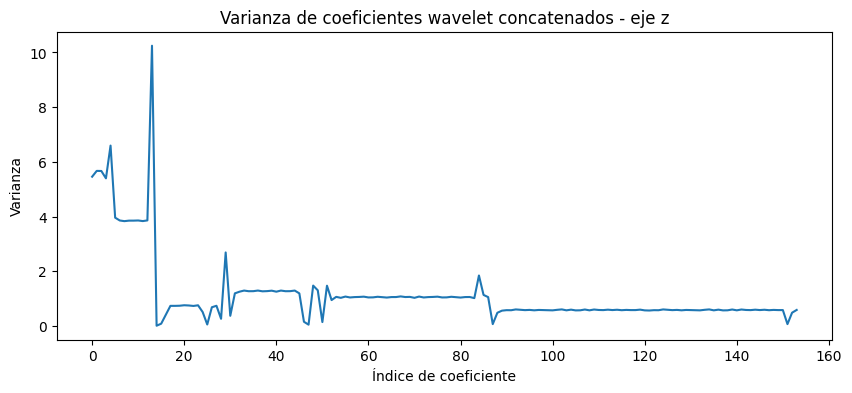

[z] Se seleccionaron 154 coeficientes wavelet con varianza > 0.001


In [13]:
for axis in ['x', 'y', 'z']:
    all_coeffs = []
    for window in windows:
        serie = window[axis].values.astype(float)
        coeffs = pywt.wavedec(serie, 'db4', level=4)
        all_coeffs.append(np.concatenate(coeffs))
    # Pad all arrays to the same length
    maxlen = max(arr.shape[0] for arr in all_coeffs)
    all_coeffs_padded = np.array([np.pad(arr, (0, maxlen - arr.shape[0]), mode='constant') for arr in all_coeffs])

    variances = np.var(all_coeffs_padded, axis=0)
    plt.figure(figsize=(10,4))
    plt.plot(variances)
    plt.title(f"Varianza de coeficientes wavelet concatenados - eje {axis}")
    plt.xlabel("Índice de coeficiente")
    plt.ylabel("Varianza")
    plt.show()

    umbral = 0.001
    selected_idx = np.where(variances > umbral)[0]
    print(f"[{axis}] Se seleccionaron {len(selected_idx)} coeficientes wavelet con varianza > {umbral}")

In [14]:
def extract_spectral_features_windows(windows, fft_k_dict, wavelet_idx_dict):
    features = []
    for window in windows:
        feats = {}
        for axis in ['x', 'y', 'z']:
            serie = window[axis].values.astype(float)
            # FFT
            fft_vals = np.fft.rfft(serie)
            fft_ampl = np.abs(fft_vals)
            fft_freqs = np.fft.rfftfreq(len(serie))
            k = fft_k_dict[axis]
            dom_freqs_idx = np.argsort(fft_ampl)[-k:][::-1]
            dom_freqs = fft_freqs[dom_freqs_idx]
            spectral_energy = np.sum(fft_ampl**2)
            # Wavelet
            coeffs = pywt.wavedec(serie, 'db4', level=4)
            wavelet_coeffs = np.concatenate(coeffs)
            wavelet_idx = wavelet_idx_dict[axis]
            # Ajustar índices si la ventana tiene menos coeficientes
            valid_idx = wavelet_idx[wavelet_idx < len(wavelet_coeffs)]
            wavelet_coeffs_feat = np.zeros(len(wavelet_idx))
            wavelet_coeffs_feat[:len(valid_idx)] = wavelet_coeffs[valid_idx]
            # Guardar features
            for i in range(k):
                feats[f'{axis}_fft_ampl_{i}'] = fft_ampl[i] if i < len(fft_ampl) else 0
                feats[f'{axis}_dom_freq_{i}'] = dom_freqs[i] if i < len(dom_freqs) else 0
            feats[f'{axis}_spectral_energy'] = spectral_energy
            for j in range(len(wavelet_idx)):
                feats[f'{axis}_wavelet_coef_{j}'] = wavelet_coeffs_feat[j]
        # Etiqueta de la ventana
        #feats['label'] = window['activity'].mode()[0]
        feats['label'] = pd.Categorical([window['activity'].mode()[0]], categories=activity_categories).codes[0]
        features.append(feats)
    return pd.DataFrame(features)

In [15]:
fft_k_dict = {'x': 28, 'y': 28, 'z': 28} #28,28,28 38,38,38   54,54,57
wavelet_idx_dict = {
    'x': np.arange(55), #90,154
    'y': np.arange(55), #90,154
    'z': np.arange(55)  #90154
}

features_spectral_df = extract_spectral_features_windows(windows, fft_k_dict, wavelet_idx_dict)

In [17]:
features_spectral_df.to_csv(os.path.join(processed_path, 'features_espectrales_labelNum_overlap50.csv'))

In [16]:
features_spectral_df

,x_fft_ampl_0,x_dom_freq_0,x_fft_ampl_1,x_dom_freq_1,x_fft_ampl_2,x_dom_freq_2,x_fft_ampl_3,x_dom_freq_3,x_fft_ampl_4,x_dom_freq_4,...,z_wavelet_coef_46,z_wavelet_coef_47,z_wavelet_coef_48,z_wavelet_coef_49,z_wavelet_coef_50,z_wavelet_coef_51,z_wavelet_coef_52,z_wavelet_coef_53,z_wavelet_coef_54,label
0,60.187566,0.0,11.307462,0.226562,10.459665,0.140625,6.504019,0.218750,2.113919,0.007812,...,0.060710,0.069657,0.922674,1.113461,-0.245729,-0.763194,0.336328,0.044630,0.758378,0
1,110.536198,0.0,24.133211,0.007812,17.018450,0.171875,6.801867,0.140625,4.475111,0.156250,...,0.115124,-0.055607,0.612173,0.782816,0.374145,1.023124,-1.071201,1.699371,-2.366863,0
2,163.272025,0.0,10.545254,0.164062,6.628917,0.171875,8.179407,0.179688,3.919006,0.187500,...,-0.223957,0.165327,-0.831824,-0.867047,0.104823,0.482180,1.352679,1.528474,-1.283715,0
3,175.867944,0.0,2.424464,0.187500,2.762582,0.179688,7.110182,0.195312,4.285198,0.171875,...,0.118232,-0.000099,0.821301,1.378654,-0.421645,-1.357944,0.067851,0.548863,0.322986,0
4,174.870724,0.0,2.807617,0.156250,2.726399,0.164062,4.318765,0.187500,2.776105,0.234375,...,0.195064,-0.105355,0.328676,-0.435535,0.199249,0.584343,-0.631033,-0.216169,-0.256419,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17153,26.293784,0.0,0.503508,0.265625,1.236887,0.132812,1.396798,0.312500,2.462659,0.085938,...,0.321651,-0.293569,0.798883,0.261408,0.036239,0.149003,0.245553,2.070611,-0.286947,3
17154,26.479212,0.0,1.386723,0.085938,0.789861,0.265625,1.886603,0.218750,1.292748,0.171875,...,-0.063891,0.069971,0.123310,-0.157882,0.084364,0.281830,-0.002768,-0.105576,1.000550,3
17155,29.653377,0.0,1.711388,0.164062,0.866661,0.242188,0.924260,0.328125,1.136602,0.289062,...,-0.081057,0.015488,-0.670708,0.191095,0.033789,0.123094,0.226511,-0.009981,-0.500452,3
17156,26.990232,0.0,2.828928,0.289062,0.749932,0.257812,1.097689,0.164062,2.496376,0.250000,...,0.283015,-0.282469,0.625255,0.185160,0.199532,0.612155,-0.279041,0.220347,0.339196,3


In [16]:
features_spectral_df.to_csv(processed_path+'/features_spectral.csv')

In [5]:
features_spectral_df = pd.read_csv(processed_path+'/features_spectral.csv')

In [6]:
features_spectral_df

,Unnamed: 0,x_fft_ampl_0,x_dom_freq_0,x_fft_ampl_1,x_dom_freq_1,x_fft_ampl_2,x_dom_freq_2,x_fft_ampl_3,x_dom_freq_3,x_fft_ampl_4,...,z_wavelet_coef_145,z_wavelet_coef_146,z_wavelet_coef_147,z_wavelet_coef_148,z_wavelet_coef_149,z_wavelet_coef_150,z_wavelet_coef_151,z_wavelet_coef_152,z_wavelet_coef_153,label
0,0,60.187566,0.0,11.307462,0.226562,10.459665,0.140625,6.504019,0.218750,2.113919,...,-0.933725,-2.276536,0.534014,-0.406904,0.447979,-0.464154,0.212599,0.133712,-0.320252,Downstairs
1,1,163.272025,0.0,10.545254,0.164062,6.628917,0.171875,8.179407,0.179688,3.919006,...,-0.361597,-0.452707,-0.879012,0.717181,-0.248873,0.587901,-0.150770,-0.490350,0.144065,Downstairs
2,2,174.870724,0.0,2.807617,0.156250,2.726399,0.164062,4.318765,0.187500,2.776105,...,0.235536,-0.360864,-0.099903,0.910814,-0.207179,-0.061093,0.026877,0.104799,-0.082300,Downstairs
3,3,183.082089,0.0,2.644759,0.156250,1.892439,0.109375,3.528953,0.164062,7.600397,...,-0.500010,0.630895,-0.510438,0.305436,-0.383665,-0.058969,0.023749,0.113339,0.320265,Downstairs
4,4,178.753018,0.0,4.573487,0.164062,3.785626,0.132812,3.767049,0.218750,3.012984,...,0.360847,-0.280786,1.495982,-1.205477,-0.436867,-0.349774,0.147014,0.329314,0.867051,Downstairs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8575,8575,29.467950,0.0,0.280846,0.226562,0.104283,0.132812,0.069791,0.359375,0.807867,...,-0.202256,0.099102,-0.129459,0.236656,0.217642,-0.174364,0.039649,0.108606,-0.329205,Walking
8576,8576,28.831365,0.0,0.585638,0.226562,1.509452,0.093750,1.025350,0.085938,2.132354,...,0.103079,-0.591610,-0.094956,-0.478705,0.236323,0.007148,-0.006293,-0.064815,-0.119130,Walking
8577,8577,26.479212,0.0,1.386723,0.085938,0.789861,0.265625,1.886603,0.218750,1.292748,...,-0.291455,0.237441,-0.102357,0.018791,0.078799,0.174018,-0.075099,-0.192216,0.006425,Walking
8578,8578,26.990232,0.0,2.828928,0.289062,0.749932,0.257812,1.097689,0.164062,2.496376,...,-0.077760,0.192810,0.591681,0.521266,0.147558,-0.268116,0.042866,0.255954,-0.369931,Walking


# Análisis multivariado 

## Correlación global

          x         y         z
x  1.000000  0.029125  0.067996
y  0.029125  1.000000  0.017386
z  0.067996  0.017386  1.000000


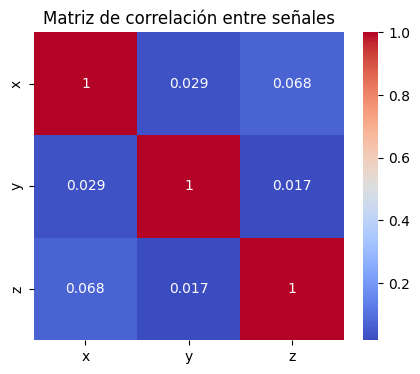

In [9]:
corr_matrix = df[['x', 'y', 'z']].corr()
print(corr_matrix)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de correlación entre señales')
plt.show()

## Correlación por actividad

In [10]:
for activity in df['activity'].unique():
    subset = df[df['activity'] == activity]
    corr = subset[['x', 'y', 'z']].corr()
    print(f"Correlación para {activity}:\n{corr}\n")

Correlación para Downstairs:
          x         y         z
x  1.000000 -0.061836  0.001159
y -0.061836  1.000000  0.019874
z  0.001159  0.019874  1.000000

Correlación para Jogging:
          x         y         z
x  1.000000  0.080272  0.102782
y  0.080272  1.000000  0.035125
z  0.102782  0.035125  1.000000

Correlación para Upstairs:
          x         y         z
x  1.000000 -0.001074 -0.082255
y -0.001074  1.000000  0.094164
z -0.082255  0.094164  1.000000

Correlación para Walking:
          x         y         z
x  1.000000 -0.102849  0.057900
y -0.102849  1.000000  0.199624
z  0.057900  0.199624  1.000000

Correlación para Sitting:
          x         y         z
x  1.000000  0.052014 -0.226092
y  0.052014  1.000000 -0.090755
z -0.226092 -0.090755  1.000000

Correlación para Standing:
          x         y         z
x  1.000000  0.382396  0.136882
y  0.382396  1.000000  0.198516
z  0.136882  0.198516  1.000000



In [26]:
project_root = os.path.dirname(os.getcwd())
data_path = os.path.join(project_root, 'data')
processed_path = data_path + '/processed'



features_temporal = pd.read_csv(processed_path + '/features_temporales.csv')

In [27]:
X_temp = features_temporal.iloc[:, :-1] 

In [28]:
# quiero ver los nulos en X_temp
print("Nulos en X_temp:")
print(X_temp.isnull().sum())

Nulos en X_temp:
Unnamed: 0    0
mean_x        0
var_x         0
skew_x        0
kurtosis_x    0
energy_x      0
entropy_x     0
mean_y        0
var_y         0
skew_y        0
kurtosis_y    0
energy_y      0
entropy_y     0
mean_z        0
var_z         0
skew_z        0
kurtosis_z    0
energy_z      0
entropy_z     0
dtype: int64
